In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import datasets

# 12.1 Principal Compoent Analysis

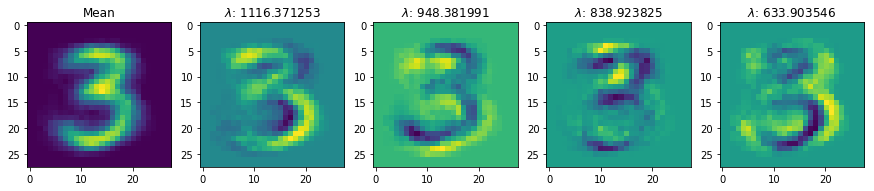

In [5]:
N = 600
data = pickle.load(open('./data.txt', 'rb'))
x_train = data['x_train']
y_train = data['y_train']
x = x_train[np.random.choice(np.where(y_train == 3)[0], 200)]
mean = np.mean(x, axis=0).reshape(1,-1)
plt.figure(figsize=[15,5])
plt.subplot(1,5,1)
plt.imshow(mean.reshape(28,28))
plt.title('Mean')

new_x = x-mean
S, sigma, V = np.linalg.svd(new_x.T)
for i in range(4):
    plt.subplot(1, 5, i+2)
    plt.imshow(S[:,i].reshape(28,28))
    plt.title('$\lambda$: %f'%sigma[i]**2)

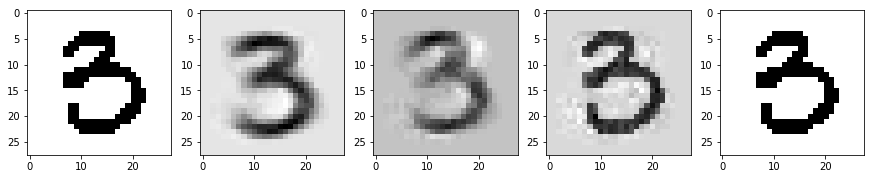

In [6]:
plt.figure(figsize=[15,5])
plt.subplot(1,5,1)
x1 = x[2,:]
plt.imshow(x1.reshape(28,28), cmap='gray_r')
idx = np.array([1,10,50,250])
for i in range(4):
    rec_x = mean + new_x[2,:].reshape(1,-1)@S[:,0:idx[i]]@S[:,0:idx[i]].T
    plt.subplot(1, 5, i+2)
    plt.imshow(rec_x.reshape(28,28), cmap='gray_r')

# 12.2.2 EM algorithm for PCA

In [18]:
iris = datasets.load_iris()
data = iris.data
y = iris.target.reshape(-1,1)

# EM algorithm
max_iter = 100
n,d = data.shape
X = data - data.mean(axis=0)
n_components = 2
I = np.eye(n_components)
W = np.eye(d, n_components)


In [22]:
n,d = data.shape

In [24]:
n

150